# Solve cartpole with REINFORCE

> By Jonas Busk ([jbusk@dtu.dk](mailto:jbusk@dtu.dk))

**2019 update:** Changes have been made to the display of environments due to the previous `viewer` being incompatible with newer versions of Gym.

**2022 update:** Rendering was disabled, and the notebook now uses the `colabgymrender` package to render a video.

**2023 update:** Changed to packages `gymnasium` and `renderlab`, and to `CartPole-v1`.

In this part, we will create an agent that can learn to solve the [cartpole problem](https://gymnasium.farama.org/environments/classic_control/cart_pole/) from OpenAI Gym by applying a simple policy gradient method called REINFORCE.
In the cartpole problem, we need to balance a pole on a cart that moves along a track by applying left and right forces to the cart.

We will implement a probabilistic policy, that given a state of the environment, $s$, outputs a probability distribution over available actions, $a$:

$$
p_\theta(a|s)
$$

The policy is a neural network with parameters $\theta$ that can be trained with gradient descent.
When the set of available actions is discrete, we can use a network with softmax output do describe the distribution.
The core idea of training the policy network is quite simple: *we want to maximize the expected total reward by increasing the probability of good actions and decreasing the probability of bad actions*.

To achieve this, we apply the gradient of the expected discounted total reward (return):

$$
\begin{align}
\nabla_\theta \mathbb{E}[R|\theta] &= \nabla_\theta \int p_\theta(a|s) R({a}) \, da \\
&= \int \nabla_\theta p_\theta(a|s) R(a)  \, da \\
&= \int p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) R(a) \, da \\
&= \mathbb{E}[\nabla_\theta \log p_\theta(a|s) R(a)]
\end{align}
$$

by definition of expectation and using the identity

$$
\nabla_\theta p_\theta(a|s) = p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) \ .
$$

The expectation cannot be evaluated analytically, but we have an environment simulator that when supplied with our current policy $p_\theta(a|s)$ can return a sequence of *actions*, *states* and *rewards*. This allows us to replace the integral with a Monte Carlo average:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) R_t \ ,
$$

which is our final gradient estimator, also known as REINFORCE. In the Monte Carlo estimator we run the environment simulator for a predefined number of steps with actions chosen stochastically according to the current stochastic action network $p_\theta(a|s)$.

*Note: For simple reinforcement learning problems (like the one we will address in this exercise) there are simpler methods that work just fine. However, the Policy Gradient method (with some extensions) has been shown to also work well for complex problems with high dimensional inputs and many parameters, where simple methods become inadequate.*

## Policy gradient

In [8]:
!pip install gymnasium
!pip install renderlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 31.5 MB/s eta 0:00:00


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import renderlab as rl

  if event.key is 'enter':



First we create the environment:

In [10]:
env = gym.make('CartPole-v1') # Create environment

A state in this environment is four numbers describing the position and speed of the cart along with the angle and angular speed of the pole.

There are two available actions: push the cart *left* or *right* encoded as 0 and 1.

In [11]:
s, _ = env.reset()
a = env.action_space.sample()
print('sample state:', s)
print('sample action:', a )

sample state: [ 0.014008   -0.04363742 -0.01565639 -0.04359629]
sample action: 0


Let us see how the environment looks when we just take random actions. Note that the episode ends when the pole either 1) is more than 15 degrees from vertical, 2) more outside of the frame or 3) the pole is successfully balanced for some fixed duration.

In [25]:
env = gym.make("CartPole-v1", render_mode = "rgb_array") # Create environment
env = rl.RenderFrame(env, "./output") # To display environment in the notebook
env.reset() # Reset environment

# Run environment
while True:
    action = env.action_space.sample() # Get a random action
    _, _, done, _, _ = env.step(action) # Take a step
    if done: break # Break if environment is done

env.close() # Close environment
env.play()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Taking random actions does not do a very good job at balancing the pole. Let us now apply the Policy Gradient method described above to solve this task!

Let's first define our network and helper functions.

In [20]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.hidden = nn.Linear(n_inputs, n_hidden)
        self.out = nn.Linear(n_hidden, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.hidden(x)
        x = F.relu(x)
        x = self.out(x)
        return F.softmax(x, dim=1)

    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))

class NewNet(nn.Module):
    def __init__(self, n_inputs, n_hidden1, n_hidden2 ,n_outputs, learning_rate):
        super(NewNet, self).__init__()

        self.hidden1 = nn.Linear(n_inputs, n_hidden1)
        self.hidden2 = nn.Linear(n_hidden1, n_hidden2)
        self.out = nn.Linear(n_hidden2, n_outputs)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.hidden1(x)
        x = F.relu(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = self.out(x)

        return  F.softmax(x, dim=1)

    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))

In [13]:
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

To start with, our policy will be a rather simple neural network with one hidden layer. We can retrieve the shape of the state space (input) and action space (output) from the environment.

In [14]:
n_inputs = env.observation_space.shape[0]
n_hidden = 20
n_outputs = env.action_space.n

print('state shape:', n_inputs)
print('action shape:', n_outputs)

state shape: 4
action shape: 2


In [16]:
# training settings

num_episodes = 800
rollout_limit = 500 # max rollout length
discount_factor = 1.0 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
val_freq = 100 # validation frequency

# setup policy network

policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        states = []
        actions =[]
        rewards = []
        s, _ = env.reset()
        for j in range(rollout_limit):
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                a = torch.multinomial(a_prob, num_samples=1).squeeze().numpy()
            s1, r, done, _, _ = env.step(a)
            states.append(s)
            actions.append(a.item())
            rewards.append(r)
            s = s1
            if done: break
        # prepare batch
        states = np.array(states)      # Shape should be (N, 4) if all states have shape (4,)
        actions = np.array(actions)    # Shape should be (N,) for actions as scalars
        rewards = np.array(rewards)
        returns = compute_returns(rewards, discount_factor)

        states_tensor = torch.from_numpy(states).float()
        actions_tensor = torch.from_numpy(actions).long().unsqueeze(1)
        # policy gradient update
        policy.optimizer.zero_grad()
        a_probs = policy(states_tensor)
        a_probs = a_probs.gather(1, actions_tensor).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s, _ = env.reset()
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                        a = a_prob.argmax().item()
                    s, r, done, _, _ = env.step(a)
                    reward += r
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')

start training
 100. mean training reward:  16.61, mean validation reward:  10.00, mean loss:  5.8332
 200. mean training reward:  18.43, mean validation reward:   9.70, mean loss:  6.5230
 300. mean training reward:  19.14, mean validation reward:   9.00, mean loss:  6.7780
 400. mean training reward:  18.87, mean validation reward:   9.90, mean loss:  6.7453
 500. mean training reward:  27.53, mean validation reward:  27.30, mean loss:  9.7459
 600. mean training reward:  26.48, mean validation reward:  27.40, mean loss:  9.3205
 700. mean training reward:  33.32, mean validation reward:  49.70, mean loss: 11.4945
 800. mean training reward:  39.26, mean validation reward:  64.90, mean loss: 13.2498
done


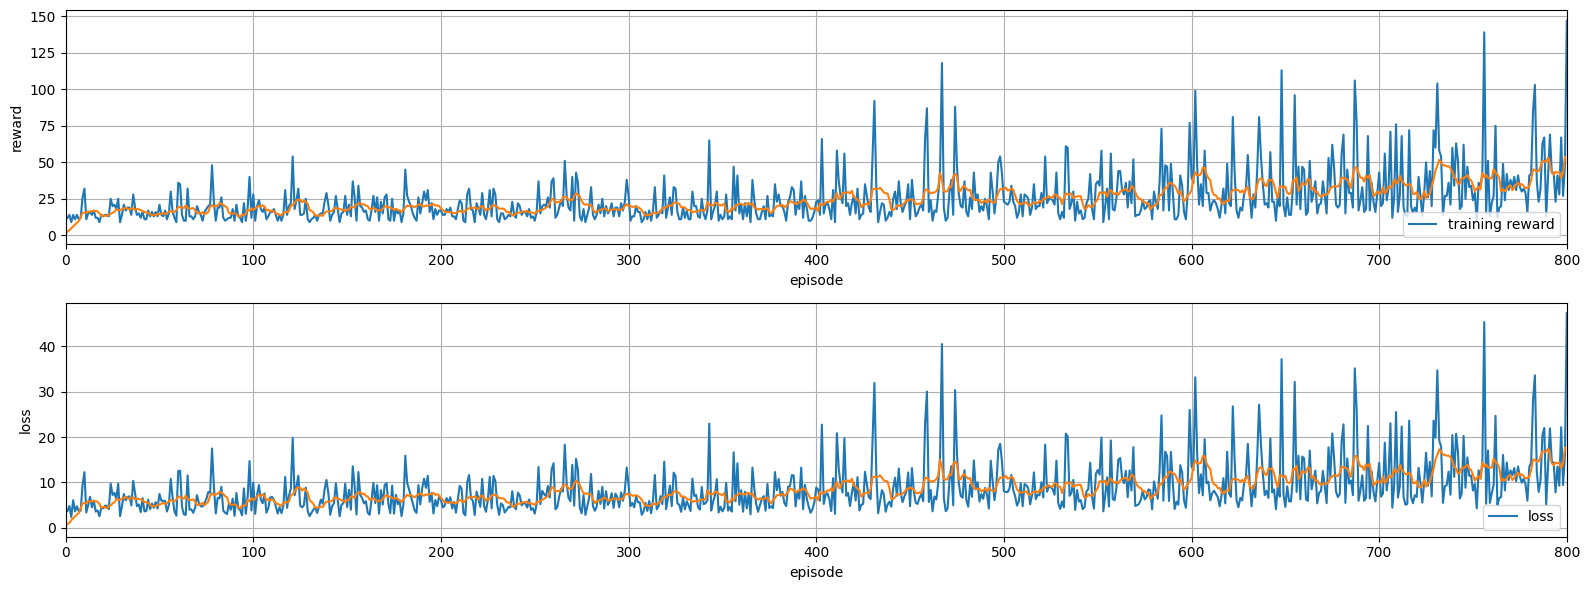

In [17]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

Now let's review the solution!

In [18]:
env = rl.RenderFrame(env, "./gym-results") # Create wrapper to display environment
s,_ = env.reset()

for _ in range(500):
    a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _, _ = env.step(a)
    if done: break

env.play()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



t:  87%|████████▋ | 81/93 [00:00<00:00, 124.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./gym-results/1730713913.3926585.mp4, 720000 bytes wanted but 0 bytes read,at frame 92/93, at time 3.07/3.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


## Reducing variance

By default, this gradient estimator has high variance and therefore variance reduction becomes important to learn more complex tasks.
We can reduce variance by subtracting a baseline from the returns, which is unbiased in expectation:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) (R_t-b_t) \ ,
$$

where the baseline, $b_t$, is estimated by the return a timestep $t$ averaged over $V$ rollouts.

$$
b_t = \frac{1}{V} \sum_{v=1}^V R_t^{(v)} \ .
$$

## Exercises

Now it is your turn! Make sure you read and understand the code, then play around with it and try to make it learn better and faster.

Experiment with the:

* number of episodes
* discount factor
* learning rate
* network layers


### Exercise 1

*Describe any changes you made to the code and why you think they improve the agent. Are you able to get solutions consistently?*

**Answer:** Code below
Initially, I experimented with decreasing the discount factor to 0.9. I reasoned that recent actions would be more critical, as they would play a vital role in stabilizing the stick if it began to fall. So it made sense to lower the discount factor to emphasize the importance of these immediate actions.
However for the same number of episodes it got worse mean training reward (MTR), which means that past actions are at least as, or more important that present actions for this challenge.

Then I experimented doubling the number of episodes maintining the discount factor at 1. It improved a lot.

After knowing that 800 episodes isnt enough for the model to converge, I tried to train with a bigger learning rate to see if it can reach similar results as the previous experiment. As expected it reached better results in a smaller timeframe.


Lastly I experimented a different Network with 2 hidden layers and more parameters and it worked much better achieving similar results to the experiment with double epochs

### Exercise 2

*Consider the following sequence of rewards produced by an agent interacting with an environment for 10 timesteps:*

[0, 1, 1, 1, 0, 1, 1, 0, 0, 0]

* *What is the total reward?*
* *What is the total future reward in each timestep?*
* *What is the discounted future reward in each timestep if $\gamma = 0.9$?*

*Hint: See introdution notebook.*

**Answer:**
The total reward is 5.
timestep, future reward, discounted future reward
### Reward Summary

| Timestep (t) | Future Reward | Discounted Future Reward                              |
|--------------|---------------|------------------------------------------------------|
| t = 0        | 5             | \(0.9 . 1 + 0.9^2 . 1 + 0.9^3 . 1 + 0.9^4 . 0 + 0.9^5 . 1 + 0.9^6 . 1 + 0.9^7 . 0 + 0.9^8 . 0 + 0.9^9 . 0 = 3.02\) |
| t = 1        | 5             | \(0.9 . 1 + 0.9^2 . 1 + 0.9^3 . 0 + 0.9^4 . 1 + 0.9^5 . 1 + 0.9^6 . 0 + 0.9^7 . 0 + 0.9^8 . 0 = 3.83\) |
| t = 2        | 4             | \(0.9 . 1 + 0.9^2 . 0 + 0.9^3 . 1 + 0.9^4 . 1 + 0.9^5 . 0 + 0.9^6 . 0 + 0.9^7 . 0 = 3.22\) |
| t = 3        | 3             | \(0.9 . 0 + 0.9^2 . 1 + 0.9^3 . 1 + 0.9^4 . 0 + 0.9^5 . 0 = 2.32\) |
| t = 4        | 2             | \(0.9 . 1 + 0.9^2 . 1 + 0.9^3 . 0 + 0.9^4 . 0 = 1.71\) |
| t = 5        | 2             | \(0.9 . 1 + 0.9^2 . 0 + 0.9^3 . 0 = 1.90\) |
| t = 6        | 1             | \(1 + 0.9 . 0 + 0.9^2 . 0 = 1.00\) |
| t = 7        | 0             | \(0 = 0\) |
| t = 8        | 0             | \(0 = 0\) |
| t = 9        | 0             | \(0 = 0\) |


### Exercise 3

*In the training output, you will sometimes observe the validation reward starts out lower than the training reward but as training progresses they cross over and the validation reward becomes higher than the training reward. How can you explain this behavior?*

*Hint: Do we use the policy network in the same way during training and validation?*

**Answer:**
During training we choose an action based on the probability of that action while in validation we always choose the action with maximum probability.

This means the training encourages exploration of new actions and seeing how they affect the state while the validation strives to get the best score by choosing the most likely answer to get a positive reward.
With time this means the training reward might not improve but the validation does

### Exercise 4

*How does the policy gradient method we have used address the exploration-exploitation dilemma?*

*Hint: See the introduction notebook about exploration-exploitation.*

**Answer:**
Explained in previous answer

### Exercise 5 [optional]

Extend the code above to reduce variance of the gradient estimator by computing and subtracting the baseline estimate.

*Hint: You need to sample a batch of rollouts (now we sample just one) for each update in order to compute the baseline, $b_t$.*

# Decreased Discount Factor

In [19]:
# training settings

num_episodes = 800
rollout_limit = 500 # max rollout length
discount_factor = 0.9 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
val_freq = 100 # validation frequency

# setup policy network

policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        states = []
        actions =[]
        rewards = []
        s, _ = env.reset()
        for j in range(rollout_limit):
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                a = torch.multinomial(a_prob, num_samples=1).squeeze().numpy()
            s1, r, done, _, _ = env.step(a)
            states.append(s)
            actions.append(a.item())
            rewards.append(r)
            s = s1
            if done: break
        # prepare batch
        states = np.array(states)      # Shape should be (N, 4) if all states have shape (4,)
        actions = np.array(actions)    # Shape should be (N,) for actions as scalars
        rewards = np.array(rewards)
        returns = compute_returns(rewards, discount_factor)

        states_tensor = torch.from_numpy(states).float()
        actions_tensor = torch.from_numpy(actions).long().unsqueeze(1)
        # policy gradient update
        policy.optimizer.zero_grad()
        a_probs = policy(states_tensor)
        a_probs = a_probs.gather(1, actions_tensor).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s, _ = env.reset()
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                        a = a_prob.argmax().item()
                    s, r, done, _, _ = env.step(a)
                    reward += r
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')

start training
 100. mean training reward:  21.77, mean validation reward:   8.80, mean loss:  4.1110
 200. mean training reward:  22.33, mean validation reward:   9.20, mean loss:  4.1436
 300. mean training reward:  23.09, mean validation reward:  10.30, mean loss:  4.2311
 400. mean training reward:  21.91, mean validation reward:   9.30, mean loss:  4.0777
 500. mean training reward:  23.79, mean validation reward:  11.10, mean loss:  4.2222
 600. mean training reward:  23.93, mean validation reward:  10.80, mean loss:  4.2058
 700. mean training reward:  22.86, mean validation reward:  10.20, mean loss:  4.2185
 800. mean training reward:  22.04, mean validation reward:   9.00, mean loss:  4.0593
done


In [22]:
env = rl.RenderFrame(env, "./gym-results") # Create wrapper to display environment
s,_ = env.reset()

for _ in range(500):
    a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _, _ = env.step(a)
    if done: break

env.play()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./gym-results/1730714479.1824217.mp4, 720000 bytes wanted but 0 bytes read,at frame 11/12, at time 0.37/0.37 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                   

Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


# Double episodes

In [23]:
# training settings

num_episodes = 1600
rollout_limit = 500 # max rollout length
discount_factor = 1 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
val_freq = 100 # validation frequency

# setup policy network

policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        states = []
        actions =[]
        rewards = []
        s, _ = env.reset()
        for j in range(rollout_limit):
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                a = torch.multinomial(a_prob, num_samples=1).squeeze().numpy()
            s1, r, done, _, _ = env.step(a)
            states.append(s)
            actions.append(a.item())
            rewards.append(r)
            s = s1
            if done: break
        # prepare batch
        states = np.array(states)      # Shape should be (N, 4) if all states have shape (4,)
        actions = np.array(actions)    # Shape should be (N,) for actions as scalars
        rewards = np.array(rewards)
        returns = compute_returns(rewards, discount_factor)

        states_tensor = torch.from_numpy(states).float()
        actions_tensor = torch.from_numpy(actions).long().unsqueeze(1)
        # policy gradient update
        policy.optimizer.zero_grad()
        a_probs = policy(states_tensor)
        a_probs = a_probs.gather(1, actions_tensor).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s, _ = env.reset()
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                        a = a_prob.argmax().item()
                    s, r, done, _, _ = env.step(a)
                    reward += r
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')

start training
 100. mean training reward:  21.06, mean validation reward:   9.20, mean loss:  7.5506
 200. mean training reward:  23.53, mean validation reward:  21.20, mean loss:  8.4068
 300. mean training reward:  24.91, mean validation reward:  37.60, mean loss:  8.8429
 400. mean training reward:  30.02, mean validation reward:  41.70, mean loss: 10.4131
 500. mean training reward:  40.48, mean validation reward:  95.20, mean loss: 13.6664
 600. mean training reward:  39.93, mean validation reward:  62.60, mean loss: 13.3187
 700. mean training reward:  41.31, mean validation reward: 119.30, mean loss: 13.6458
 800. mean training reward:  48.68, mean validation reward: 156.70, mean loss: 15.6550
 900. mean training reward:  56.73, mean validation reward: 313.00, mean loss: 18.0652
1000. mean training reward:  81.66, mean validation reward: 313.50, mean loss: 25.5227
1100. mean training reward: 113.52, mean validation reward: 413.90, mean loss: 34.7198
1200. mean training reward: 

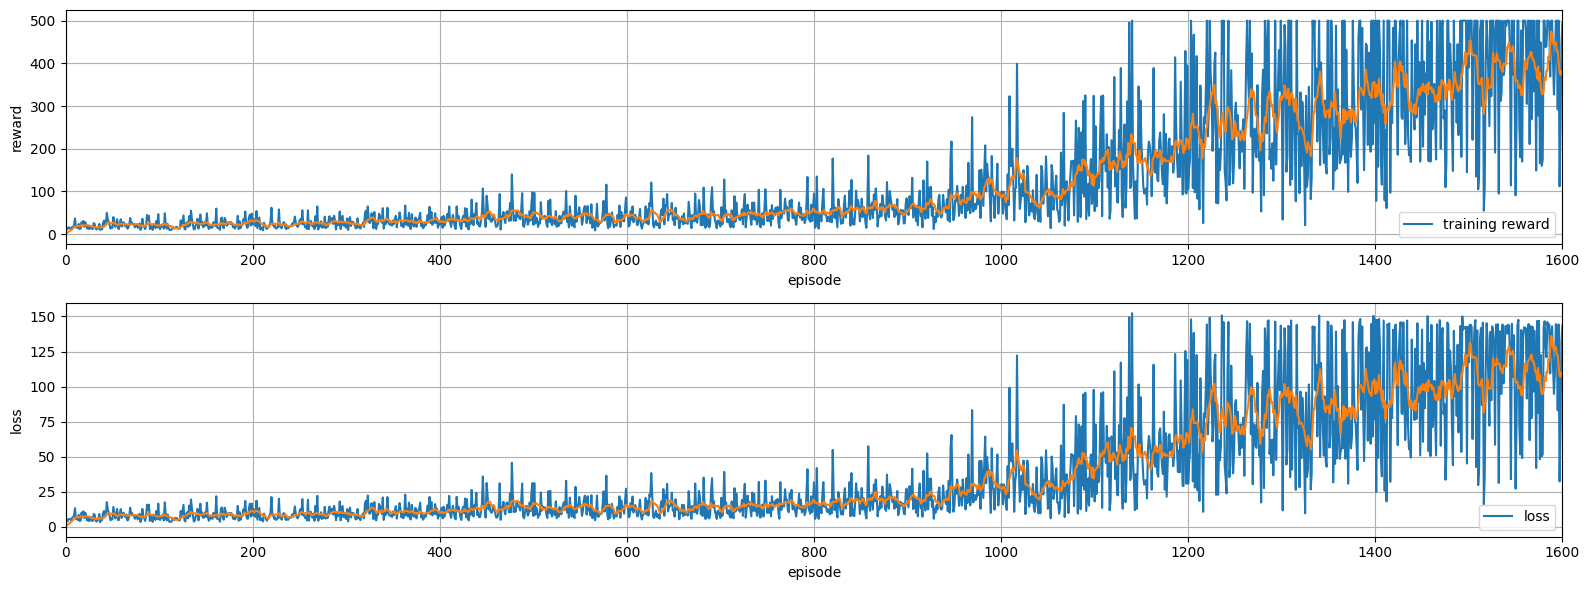

In [24]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

In [25]:
env = rl.RenderFrame(env, "./gym-results") # Create wrapper to display environment
s,_ = env.reset()

for _ in range(500):
    a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _, _ = env.step(a)
    if done: break

env.play()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


# Learning rate

In [26]:
# training settings

num_episodes = 800
rollout_limit = 500 # max rollout length
discount_factor = 1 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.01 # you know this by now
val_freq = 100 # validation frequency

# setup policy network

policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        states = []
        actions =[]
        rewards = []
        s, _ = env.reset()
        for j in range(rollout_limit):
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                a = torch.multinomial(a_prob, num_samples=1).squeeze().numpy()
            s1, r, done, _, _ = env.step(a)
            states.append(s)
            actions.append(a.item())
            rewards.append(r)
            s = s1
            if done: break
        # prepare batch
        states = np.array(states)      # Shape should be (N, 4) if all states have shape (4,)
        actions = np.array(actions)    # Shape should be (N,) for actions as scalars
        rewards = np.array(rewards)
        returns = compute_returns(rewards, discount_factor)

        states_tensor = torch.from_numpy(states).float()
        actions_tensor = torch.from_numpy(actions).long().unsqueeze(1)
        # policy gradient update
        policy.optimizer.zero_grad()
        a_probs = policy(states_tensor)
        a_probs = a_probs.gather(1, actions_tensor).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s, _ = env.reset()
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                        a = a_prob.argmax().item()
                    s, r, done, _, _ = env.step(a)
                    reward += r
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')

start training
 100. mean training reward:  24.23, mean validation reward:  38.40, mean loss:  8.2197
 200. mean training reward:  44.49, mean validation reward:  34.90, mean loss: 13.8925
 300. mean training reward:  95.60, mean validation reward: 102.10, mean loss: 26.7532
 400. mean training reward: 238.02, mean validation reward: 329.30, mean loss: 54.5629
 500. mean training reward: 173.29, mean validation reward: 291.70, mean loss: 26.5661
 600. mean training reward: 197.99, mean validation reward: 120.70, mean loss: 31.5436
 700. mean training reward: 165.47, mean validation reward: 141.00, mean loss: 27.0586
 800. mean training reward: 125.04, mean validation reward: 106.00, mean loss: 18.6888
done


In [1]:
env = rl.RenderFrame(env, "./gym-results") # Create wrapper to display environment
s,_ = env.reset()

for _ in range(500):
    a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _, _ = env.step(a)
    if done: break

env.play()

NameError: name 'rl' is not defined

Different Neural Network

In [21]:
# training settings

num_episodes = 800
rollout_limit = 500 # max rollout length
discount_factor = 1.0 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
val_freq = 100 # validation frequency

# setup policy network
n_hidden1=40
n_hidden2=40
policy = NewNet(n_inputs, n_hidden1, n_hidden2, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        states = []
        actions =[]
        rewards = []
        s, _ = env.reset()
        for j in range(rollout_limit):
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                a = torch.multinomial(a_prob, num_samples=1).squeeze().numpy()
            s1, r, done, _, _ = env.step(a)
            states.append(s)
            actions.append(a.item())
            rewards.append(r)
            s = s1
            if done: break
        # prepare batch
        states = np.array(states)      # Shape should be (N, 4) if all states have shape (4,)
        actions = np.array(actions)    # Shape should be (N,) for actions as scalars
        rewards = np.array(rewards)
        returns = compute_returns(rewards, discount_factor)

        states_tensor = torch.from_numpy(states).float()
        actions_tensor = torch.from_numpy(actions).long().unsqueeze(1)
        # policy gradient update
        policy.optimizer.zero_grad()
        a_probs = policy(states_tensor)
        a_probs = a_probs.gather(1, actions_tensor).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s, _ = env.reset()
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                        a = a_prob.argmax().item()
                    s, r, done, _, _ = env.step(a)
                    reward += r
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')

start training
 100. mean training reward:  22.44, mean validation reward:  60.80, mean loss:  8.1038
 200. mean training reward:  33.44, mean validation reward: 265.50, mean loss: 11.5068
 300. mean training reward:  73.95, mean validation reward: 284.20, mean loss: 22.7346
 400. mean training reward: 143.65, mean validation reward: 374.20, mean loss: 42.6214
 500. mean training reward: 187.78, mean validation reward: 218.90, mean loss: 52.8936
 600. mean training reward: 229.51, mean validation reward: 352.60, mean loss: 60.4536
 700. mean training reward: 445.30, mean validation reward: 500.00, mean loss: 107.4440
 800. mean training reward: 466.82, mean validation reward: 500.00, mean loss: 107.6129
done


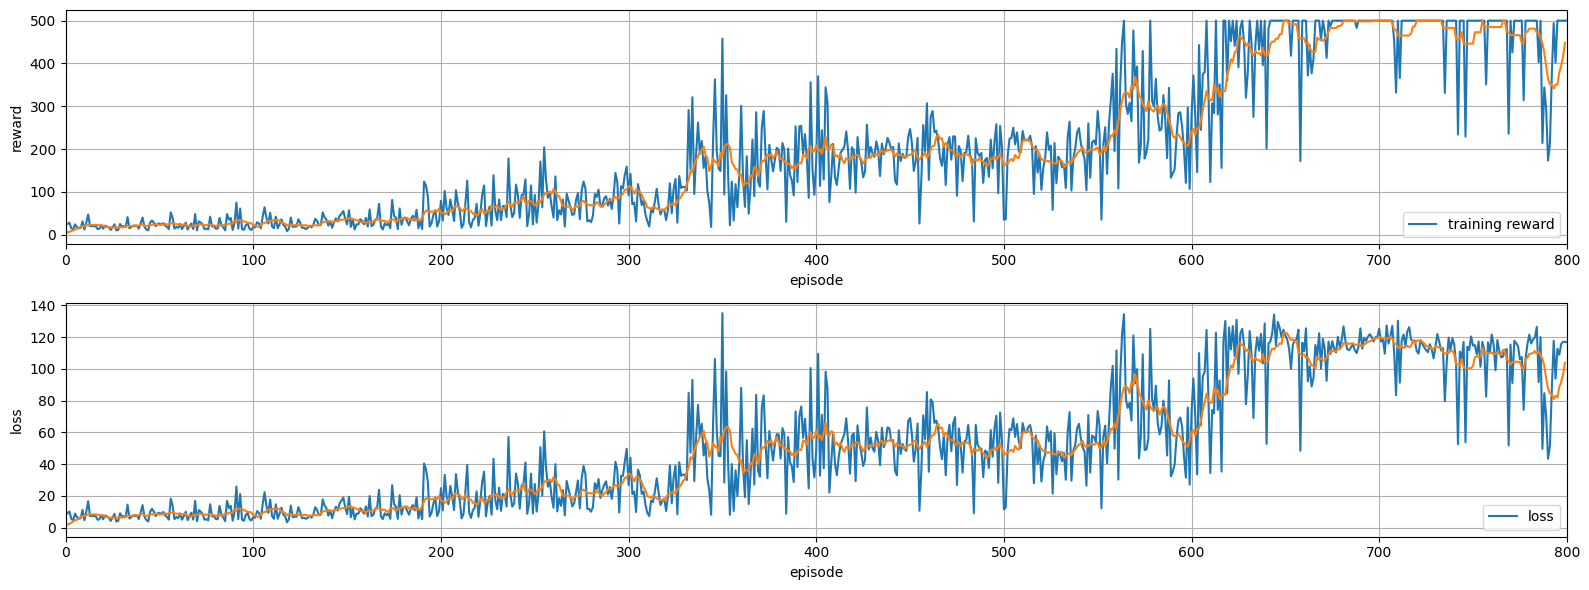

In [22]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

In [26]:
env = rl.RenderFrame(env, "./gym-results") # Create wrapper to display environment
s,_ = env.reset()

for _ in range(500):
    a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _, _ = env.step(a)
    if done: break

env.play()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4
